In [5]:
import os.path as osp
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def read_sdf(file):
    """
    Read sdf file and return a list of molecules
    """
    suppl = Chem.SDMolSupplier(file)
    mols = [x for x in suppl]
    return mols


def get_canonical_smiles(smiles_list):
    canonical_smiles_set = set()
    for smiles in tqdm(smiles_list, desc="Processing SMILES"):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            canonical_smiles_set.add(Chem.MolToSmiles(mol))
    return list(canonical_smiles_set)

def write_txt(smiles_list,file):
    with open(file, "w") as f:
        for smiles in smiles_list:
            f.write(smiles + "\n")

def read_txt(file):
    with open(file, "r") as f:
        smiles_list = [line.strip() for line in f]
    return smiles_list


def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol,n_bits))
    return fp_list

def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,),int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def write_pkl(obj,file):
    with open(file, "wb") as f:
        pickle.dump(obj, f)

def read_pkl(file):
    with open(file, "rb") as f:
        obj = pickle.load(f)
    return obj

In [3]:
crossdock_smi = read_txt('./crossdock_mols.txt')
moses_smi = read_txt('./moses2.txt')

In [4]:
scale = 100
cross_fp_list = fp_list_from_smiles_list(crossdock_smi[:len(crossdock_smi)//scale])
moses_fp_list = fp_list_from_smiles_list(moses_smi[:len(moses_smi)//scale])

100%|██████████| 19369/19369 [00:02<00:00, 9303.88it/s]


PCA Approach

In [22]:
# perform pca
pca_2 = PCA(n_components=2)
pca_2.fit(moses_fp_list)
cross_dock_2 = pca_2.transform(cross_fp_list)
moses_2 = pca_2.transform(moses_fp_list)

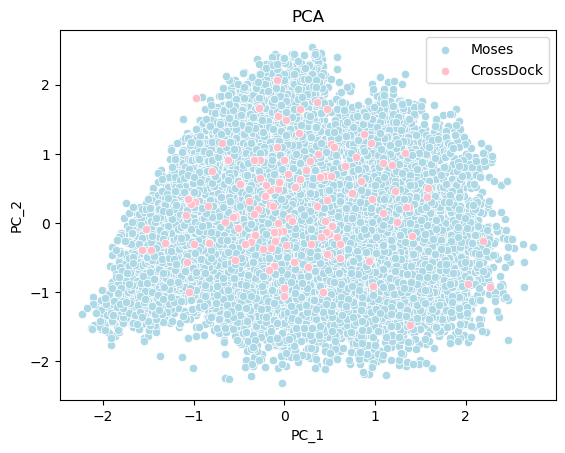

In [23]:
import matplotlib.pyplot as plt

# Assuming crds_df is a pandas DataFrame


fig, ax = plt.subplots()

# Scatter plot for inactive data with white edge color
ax.scatter(moses_2[:,0], moses_2[:,1], color='lightblue', edgecolor='white', linewidths=0.5, label='Moses')
ax.scatter(cross_dock_2[:,0], cross_dock_2[:,1], color='pink', edgecolor='white', linewidths=0.5, label='CrossDock')
# # Scatter plot for active data with white edge color and specific edge width
# ax.scatter(active_df["PC_1"], active_df["PC_2"], color='red', edgecolor='white', linewidths=0.5, label='Active')


# Setting labels, title, and legend
ax.set_xlabel("PC_1")
ax.set_ylabel("PC_2")
ax.set_title("PCA")
ax.legend()

# Display the plot
plt.show()


t-SNE

In [14]:
# perform pca for the following t-SNE
pca_50 = PCA(n_components=25)
pca_50.fit(cross_fp_list)
cross_dock_50 = pca_50.transform(cross_fp_list)
moses_50 = pca_50.transform(moses_fp_list)

In [16]:
tsne = TSNE(n_components=2, verbose=0, perplexity=2, n_iter=250)

# Concatenate the datasets
combined_data = np.vstack([cross_dock_50, moses_50])

# Fit t-SNE to the combined dataset
combined_transformed = tsne.fit_transform(combined_data)

# Separate the transformed data
crossdock_transformed_new = combined_transformed[:len(cross_fp_list)]
moses_transformed_new = combined_transformed[len(cross_fp_list):]

# Now, crossdock_transformed_new and moses_transformed_new are in the same t-SNE space.


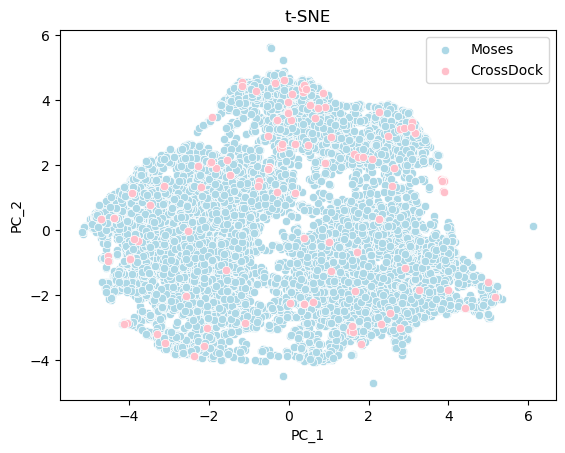

In [21]:
import matplotlib.pyplot as plt

# Assuming crds_df is a pandas DataFrame


fig, ax = plt.subplots()

# Scatter plot for inactive data with white edge color
ax.scatter(moses_transformed_new[:,0] , moses_transformed_new[:,1], color='lightblue', edgecolor='white', linewidths=0.5, label='Moses')
ax.scatter(crossdock_transformed_new[:,0], crossdock_transformed_new[:,1], color='pink', edgecolor='white', linewidths=0.5, label='CrossDock')
# # Scatter plot for active data with white edge color and specific edge width
# ax.scatter(active_df["PC_1"], active_df["PC_2"], color='red', edgecolor='white', linewidths=0.5, label='Active')


# Setting labels, title, and legend
ax.set_xlabel("PC_1")
ax.set_ylabel("PC_2")
ax.set_title("t-SNE")
ax.legend()

# Display the plot
plt.show()
